In [ ]:
!pip install -U scikit-learn -i https://pypi.tuna.tsinghua.edu.cn/simple

In [35]:
import tensorflow as tf
import api.capital_features_api as cf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import numpy as np

tf.config.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
train_data = cf.get_train_data(cf.prod_train_data_url, train_config_id=35602)
validation_data = cf.get_train_data(cf.prod_train_data_url, train_config_id=35603)

In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data['featuresT'], train_data['upSignals']))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data['featuresT'], validation_data['upSignals']))
BATCH_SIZE = 64  # 你可以根据需要调整这个值
train_dataset = train_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

In [8]:
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data['upSignals']),
    y=train_data['upSignals']
)
class_weights = dict(zip(np.unique(train_data['upSignals']), weights))

In [40]:
model = Sequential([
    InputLayer(input_shape=(6, 11)),
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])
model.summary()
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 6, 128)            71680     
                                                                 
 dropout_20 (Dropout)        (None, 6, 128)            0         
                                                                 
 batch_normalization_10 (Bat  (None, 6, 128)           512       
 chNormalization)                                                
                                                                 
 lstm_15 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_11 (Bat  (None, 64)               256       
 chNormalization)                                     

In [41]:
his_up = model.fit(train_dataset, epochs=20, validation_data=validation_dataset, verbose=1,
                   callbacks=[early_stopping, reduce_lr, lr_scheduler], class_weight=class_weights)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
320/320 [==============================] - 8s 17ms/step - loss: 0.7926 - acc: 0.5518 - precision: 0.4543 - recall: 0.5511 - val_loss: 0.7648 - val_acc: 0.5283 - val_precision: 0.4829 - val_recall: 0.4197 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
320/320 [==============================] - 5s 15ms/step - loss: 0.7462 - acc: 0.5565 - precision: 0.4619 - recall: 0.6031 - val_loss: 0.7704 - val_acc: 0.5085 - val_precision: 0.4683 - val_recall: 0.5387 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/20
320/320 [==============================] - 5s 15ms/step - loss: 0.7201 - acc: 0.5575 - precision: 0.4645 - recall: 0.6341 - val_loss: 0.7385 - val_acc: 0.4970 - val_precision: 0.4659 - val_recall: 0.6693 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.00100000004749745

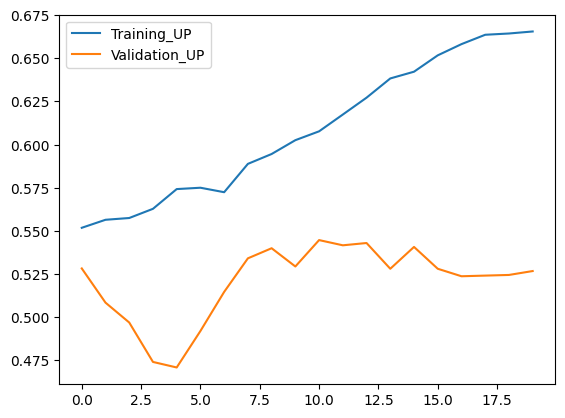

In [42]:
plt.plot(his_up.history['acc'], label='Training_UP')
plt.plot(his_up.history['val_acc'], label='Validation_UP')
plt.legend()
plt.show()

In [43]:
len(validation_data['upSignals'])

5300

In [44]:
validation_data['upSignals'].count(1)

2428

In [45]:
validation_data['upSignals'].count(0)

2872